<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BNLP_04%5DTry_changing_the_Vocabulary_Size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [NLP_04]Try changing the Vocabulary Size

지금까지는 모델을 변경하고, 모델을 조합해서 성능을 올리는 일에 힘썼습니다. 그런데 어쩌면 성능을 높이는 방법은 단순히 모델을 조정하는 일에 한정되지 않을 수 있습니다. 데이터의 전처리는 모델의 성능에 영향을 직접적으로 줍니다. 특히나 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있겠죠.

중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있습니다. 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있습니다.

> 따라서 단어의 수에 따라 모델의 성능이 어떻게 변하는지 테스트 해보겠습니다. 앞서 num_words로 사용할 단어의 수를 조정할 수 있다는 것을 배웠습니다. 빈도수가 많은 순서대로 나열했을 때, num_words의 인자로 준 정숫값만큼의 단어를 사용하고 나머지 단어는 전부 <unk>로 처리하는 원리였었죠.

함수구현 프로세스
- 데이터셋 함수
    - 세 분류 데이터 로드 : 모든 단어, 빈도수 상위 5,000개 단어, 빈도수 상위 1,000개 단어
    - 샘플데이터수 확인
    - 

## 1. Import 및 데이터 로드

In [1]:
# 기본 import 
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 벡터화
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# sklearn Mldel import
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# 평가
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 2. 함수구현

### 1) data_load
- 데이터 불러오기
- 데이터 분석
- 데이터 텍스트로 변환
- 데이터 벡터화

In [7]:
def test(x, y):
  print(x)
  print(y)

In [8]:
test(100, 10.2)

100
10.2


In [9]:
def data_load(num_words=None, test_split=0.2):
  (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=test_split)

  print('-'*25,'샘플수','-'*25)
  print('훈련 샘플의 수 : {}'.format(len(x_train)))
  print('테스트 샘플의 수 : {}'.format(len(x_test)))

  print()
  print('-'*25,'클래스의 수','-'*25)
  num_classes = max(y_train) + 1
  print('클래스의 수 : {}'.format(num_classes))

  print()
  print('-'*25,'길이','-'*25)
  print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
  print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

  print()
  print('-'*25,'데이터 분포','-'*25)
  plt.hist([len(s) for s in x_train], bins=50)
  plt.xlabel('length of samples')
  plt.ylabel('number of samples')
  plt.show()

  print()
  print('-'*25,'클래스 분포','-'*25)
  fig, axe = plt.subplots(ncols=1)
  fig.set_size_inches(11,5)
  sns.countplot(x=y_train)
  plt.show()

  ## 데이터 텍스트로 처리
  word_index = reuters.get_word_index(path='reuters_word_index.json')
  index_to_word = {index+3 : word for word, index in word_index.items()}
  for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
    index_to_word[index]=token

  decoded = []
  for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

  x_train = decoded

  decoded = []
  for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

  x_test = decoded

  # 데이터 벡터화
  dtmvector = CountVectorizer()
  tfidf_transformer = TfidfTransformer()

  x_train_dtm = dtmvector.fit_transform(x_train)
  tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

  x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
  tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

  return tfidfv, y_train, tfidfv_test, y_test


2121728/2110848 [==============================] - 0s 0us/step
------------------------- 샘플수 -------------------------
훈련 샘플의 수 : 8982
테스트 샘플의 수 : 2246

------------------------- 클래스의 수 -------------------------
클래스의 수 : 46

------------------------- 길이 -------------------------
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633

------------------------- 데이터 분포 -------------------------


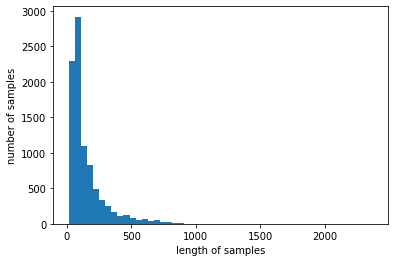


------------------------- 클래스 분포 -------------------------


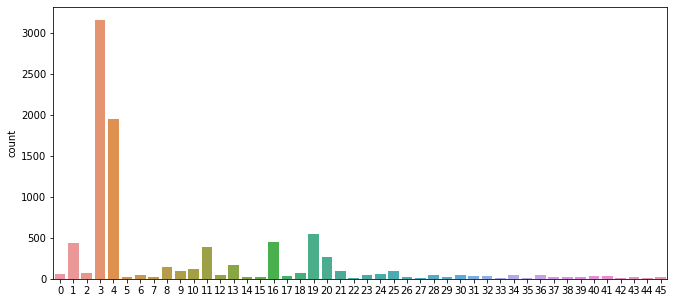

565248/550378 [==============================] - 0s 0us/step


In [10]:
tfidfv, y_train, tfidfv_test, y_test = data_load(10000)

### 2) ML_Models

In [11]:
def ML_Models(tfidfv, y_train, tfidfv_test, y_test):
  # 다항분포 나이브 베이즈
  mnb = MultinomialNB()
  mnb.fit(tfidfv, y_train)
  predicted = mnb.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("다항분포 나이브 베이즈 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

  # Complement Naive Bayes Classifier(CNB)
  cb = ComplementNB()
  cb.fit(tfidfv, y_train)
  predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("컴플리먼트 나이브 베이즈 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

  # 로지스틱 회귀 분석
  lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
  lr.fit(tfidfv, y_train)
  predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("로지스틱 회귀 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

  # 선형 서포트 벡터 머신
  lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
  lsvc.fit(tfidfv, y_train)
  predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("선형 서포트 벡터 머신 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

  # 결정 트리
  tree = DecisionTreeClassifier(max_depth=10, random_state=0)
  tree.fit(tfidfv, y_train)
  predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("결정 트리 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

  # 랜덤 포레스트
  forest = RandomForestClassifier(n_estimators=5, random_state=0)
  forest.fit(tfidfv, y_train)
  predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("랜덤 포레스트 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

  # 그레디언 부스트
  grbt = GradientBoostingClassifier(random_state=0) # verbose=3
  grbt.fit(tfidfv, y_train)
  predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("그레디언 부스트 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

  # 보팅
  voting_classifier = VotingClassifier(estimators=[
          ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
          ('cb', ComplementNB()),
          ('grbt', GradientBoostingClassifier(random_state=0))
  ], voting='soft')
  voting_classifier.fit(tfidfv, y_train)
  predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("보팅 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

  return mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier


In [12]:
mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier = ML_Models(tfidfv, y_train, tfidfv_test, y_test)

나이브 베이즈 정확도: 0.6567230632235085
컴플리먼트 나이브 베이즈 정확도: 0.7707034728406055
로지스틱 회귀 정확도: 0.8107747105966162


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


선형 서포트 벡터 머신 정확도: 0.7867319679430098
결정 트리 정확도: 0.6202137132680321
랜덤 포레스트 정확도: 0.674087266251113
그레디언 부스트 정확도: 0.7666963490650045
보팅 정확도: 0.8165627782724845


### 3) F1-Score, Confusion Matrix


In [23]:
def fcm(models, tfidfv_test, y_test):
  for model in models:
    if model == mnb:
      model_name = 'Multinomial Naive Bayes Classifier'
    elif model == cb:
      model_name = 'Complement Naive Bayes Classifier'
    elif model == lr:
      model_name = 'Logistic Regression'
    elif model == lsvc:
      model_name = 'Linear Support Vector Machine'
    elif model == tree:
      model_name = 'Decision Tree'
    elif model == forest:
      model_name = 'Random Forest'
    elif model == grbt:
      model_name = 'GradientBoostingClassifier'
    else:
      model_name = 'Voting'
    
    print('-'*25,model_name,'-'*25)
    print()
    print("f1-score : ", classification_report(y_test, model.predict(tfidfv_test), zero_division=0))


    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(tfidfv_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(12,12))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('{} label'.format(model_name))
    plt.xlabel('{} predicted value'.format(model_name))

------------------------- Multinomial Naive Bayes Classifier -------------------------

f1-score :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00  

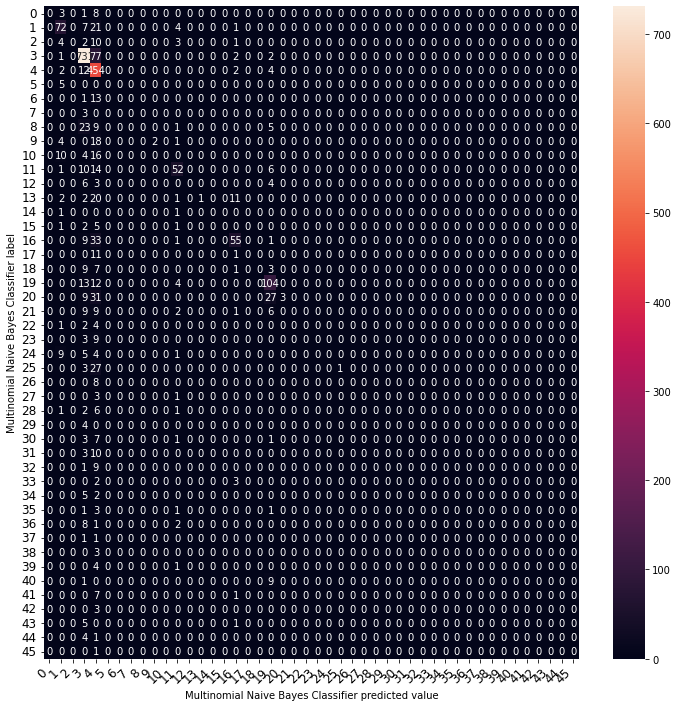

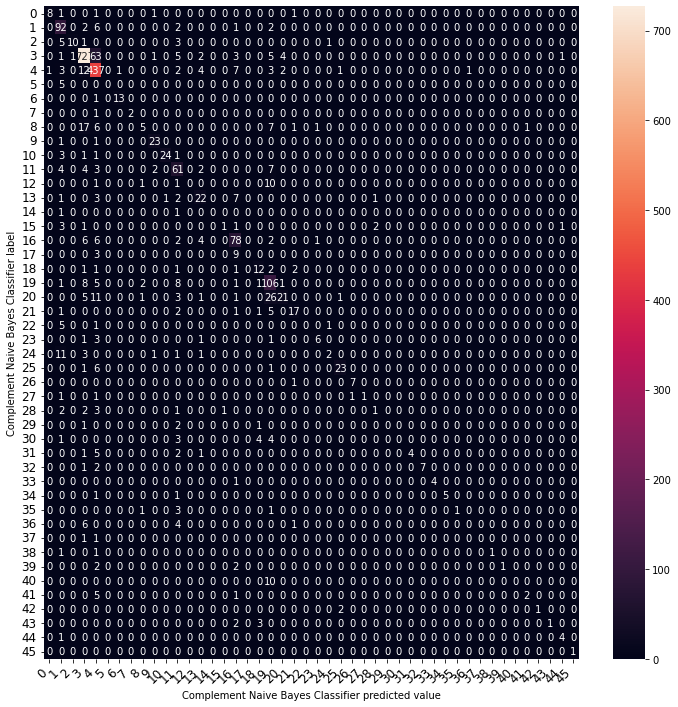

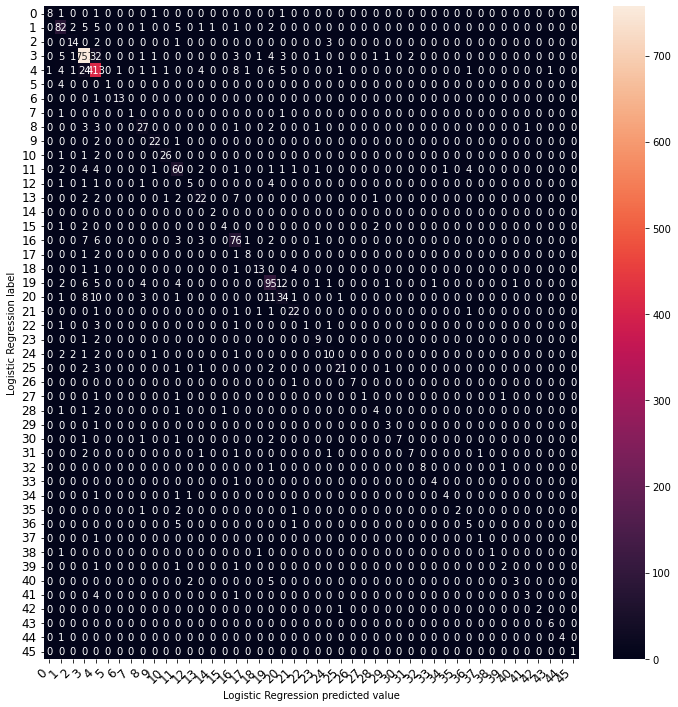

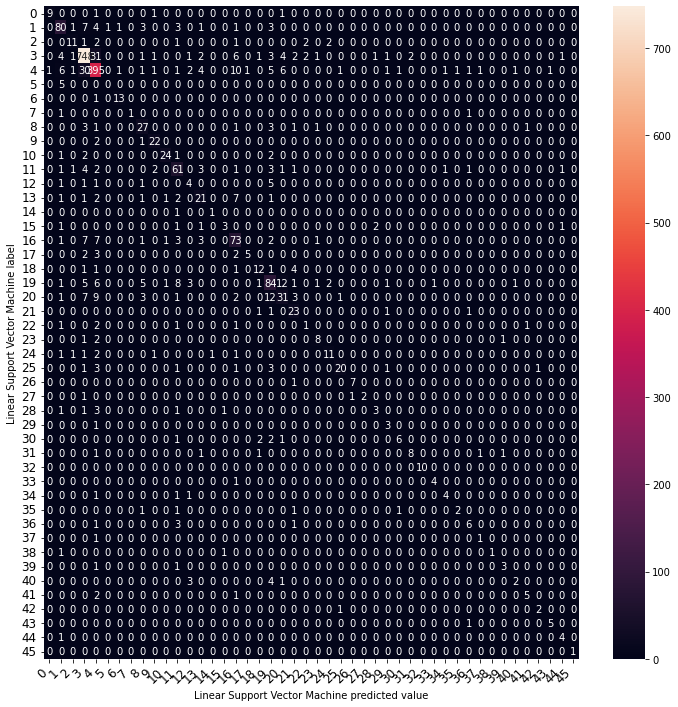

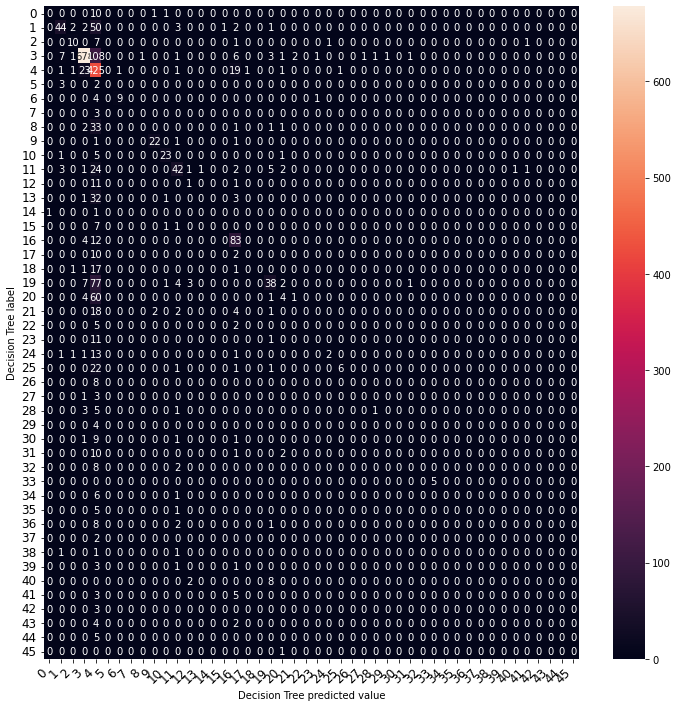

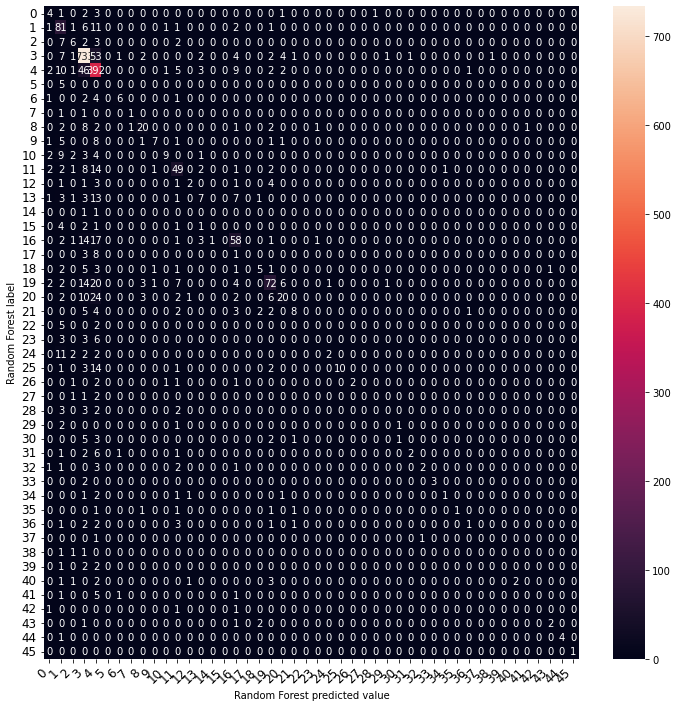

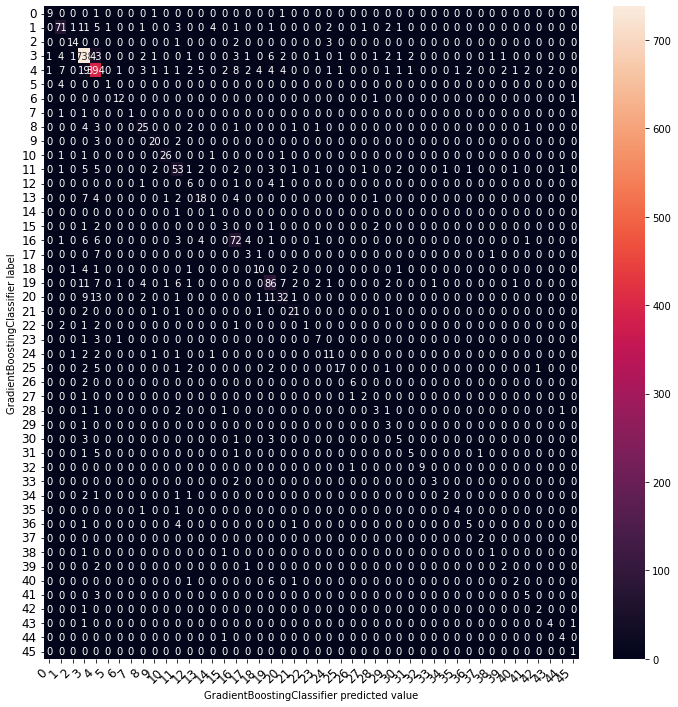

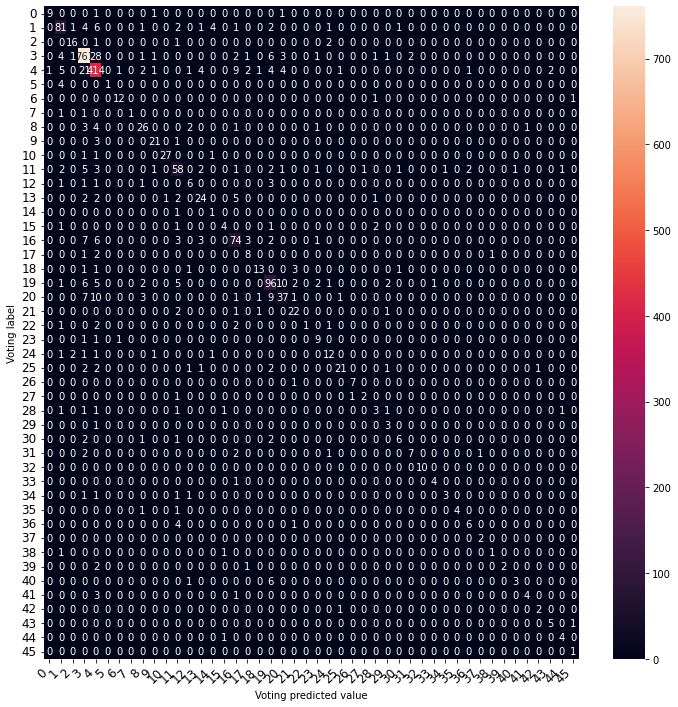

In [24]:
models = [mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier]
fcm(models, tfidfv_test, y_test)

## 2. 모든 단어 사용

------------------------- 샘플수 -------------------------
훈련 샘플의 수 : 8982
테스트 샘플의 수 : 2246

------------------------- 클래스의 수 -------------------------
클래스의 수 : 46

------------------------- 길이 -------------------------
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633

------------------------- 데이터 분포 -------------------------


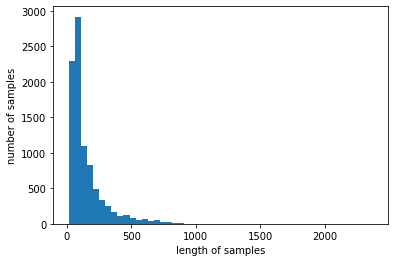


------------------------- 클래스 분포 -------------------------


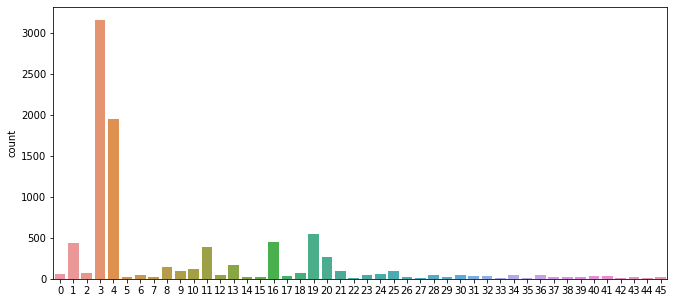


------------------------- 클래스 분포 -------------------------


## 1) 데이터 로드 및 분석

In [4]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


In [5]:
print('훈련 샘플의 수 : {}'.format(len(x_train)))
print('테스트 샘플의 수 : {}'.format(len(x_test)))

훈련 샘플의 수 : 8982
테스트 샘플의 수 : 2246


In [6]:
print(x_train[0])
print(x_test[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 23406, 28185, 5, 192,

In [7]:
print(y_train[0])
print(y_test[0])

3
3


In [8]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


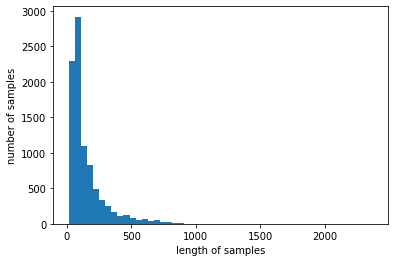

In [10]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

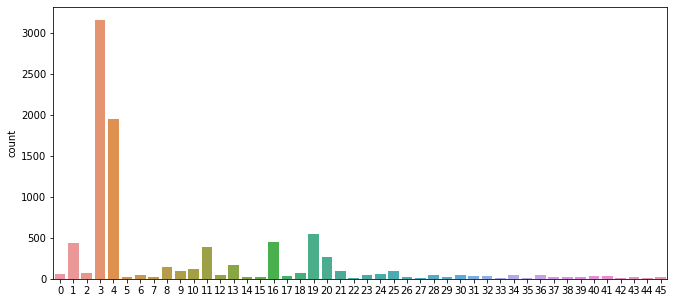

In [11]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [12]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print('각 클래스 빈도수 : ')
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수 : 
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 2) 데이터 복원하기

In [14]:
word_index = reuters.get_word_index(path='reuters_word_index.json')

565248/550378 [==============================] - 0s 0us/step


In [15]:
index_to_word = {index+3 : word for word, index in word_index.items()}

In [16]:
for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
  index_to_word[index]=token

In [17]:
decoded = []
for i in range(len(x_train)):
  t = ' '.join([index_to_word[index] for index in x_train[i]])
  decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [18]:
decoded = []
for i in range(len(x_test)):
  t = ' '.join([index_to_word[index] for index in x_test[i]])
  decoded.append(t)

x_test = decoded
print(len(x_test))

2246


### 3) 벡터화

In [25]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


In [26]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


In [27]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

## 3. 빈도수 상위 5000개의 단어만 사용

## 4. 직접 단어 개수를 설정해서 사용

## 5. 딥러닝 모델과 비교하기

1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?
  - 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.

2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
  - Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.

3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?
  - 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.